```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture21-QuantumMechanics.pdf)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Matrix methods for quantum mechanics

Time-independent Schrödinger equation reads

$$
\left[-\frac{\hbar^2}{2m} \frac{d^2 }{dx^2} + V(x)\right] \psi(x) = E \psi(x).
$$

Let us say we have boundary conditions $\psi(-L/2) = \psi(L/2) = 0$.

The usual task here is to find the eigenenergies $E_n$ and eigenstates $\psi_n(x)$, such that 

$$
H \psi_n(x) = E_n \psi_n(x).
$$

Linear algebra methods provide a powerful tool to solve this problem, as we can represent the problem in a matrix form.

## Matrix method for eigenenergies and eigenstates

By discretizing the space into $N$ intervals, we can represent the wave function $\psi(x)$ as an $(N+1)$-dimensional vector $\mathbf{\psi} = (\psi_0,\ldots,\psi_{N})$ such that

$$
\psi_k = \psi(x_k), \qquad x_k = -L/2 + k dx, \qquad dx = L/N.
$$

Due to boundary conditions we have $\psi_0 = \psi_{N} = 0$, thus effectively we deal with $(N-1)$-dimensional space.

Each operator becomes a $(N-1) \times (N-1)$ matrix. By discretizing $\frac{d^2 }{dx^2}$ by the central difference we get

$$
\frac{d^2}{dx^2} \psi_n \approx \frac{\psi_{n+1} - 2\psi_n + \psi_{n-1}}{dx^2}.
$$

Therefore, the Hamiltonian, has the following matrix representation

$$
H_{nm} = -\frac{\hbar^2}{2m} \left[ \delta_{m,n+1} \psi_{n+1} - 2 \delta_{m,n} \psi_{n} + \delta_{m,n-1} \psi_{n-1} \right] + \delta_{m,n} V(x_n),
$$

i.e. $H$ is a tridiagonal symmetric matrix.

Therefore finding the energies and wave function of the system corresponds to the matrix eigenvalue problem for the matrix $H$, i.e. we look for eigenstates $\psi_n$ and eigenenergies $E_n$ such that

$$
\sum_{m=1}^{N-1} H_{nm} \psi_m = E_n \psi_n
$$

Let us apply the method to (an)harmonic oscillator, where:

$$
V(x) = V_0 x^2 / a^2 \qquad \text{for harmonic oscillator}
$$

and

$$
V(x) = V_0 x^4 / a^4 \qquad \text{for anharmonic oscillator}
$$

In [2]:
# Constants
me = 9.1094e-31    # Mass of electron
hbar = 1.0546e-34  # Planck's constant over 2*pi
e = 1.6022e-19     # Electron charge
V0 = 50*e
a  = 1e-11
N = 100
L = 20*a
dx = L/N

# Potential functions
def Vharm(x):
    return V0 * x**2 / a**2

def Vanharm(x):
    return V0 * x**4 / a**4

# Construct the Hamiltonian matrix
def HamiltonianMatrix(V):
    H = (-hbar**2 / (2*me*dx**2)) * (np.diag((N-2)*[1],-1) + np.diag((N-1)*[-2],0) + np.diag((N-2)*[1],1)) 
    H += np.diag([V(-0.5 * L + dx*(k+0.5)) for k in range(1,N)],0)
    return H

# Compute the normalisation factor with trapezoidal rule
def integral_psi2(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N):
        ret += psi[k] * np.conj(psi[k]) + psi[k+1] * np.conj(psi[k+1])
    
    ret *= 0.5 * dx
    
    return ret

# Compute the integral (to determine the sign)
def integral_psi(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N//2):
        ret += psi[k] + psi[k+1]
    
    ret *= 0.5 * dx
    
    return ret

Since our matrix is real symmetric, we can use a straightforward implementation of the QR algorithm.
We thus expect to obtain representation of $H$ in form

$$
H = Q^T A Q
$$

where $A$ is diagonal and contains the energies, while $Q$ is orthogonal and has eigenvectors (wave functions) in its columns.

In [3]:
# Simple implementation of the QR algorithm
# For real symmetric matrix we expect
# A to converge to diagonal matrix with eigenvalues
# and Q to have eigenvectors in each column
def eigen_qr_simple(A, iterations=100):
    Ak = np.copy(A)
    n = len(A[0])
    QQ = np.eye(n)
    for k in range(iterations):
        Q, R = np.linalg.qr(Ak)
        Ak = np.dot(R,Q)
        QQ = np.dot(QQ,Q)
    return Ak, QQ

Using simple QR decomposition
First 10 eigenenergies of Harmonic oscillator are
E_ 0 = 137.89885851581894 eV
E_ 1 = 413.4458926008829 eV
E_ 2 = 688.4908722178074 eV
E_ 3 = 963.032414764268 eV
E_ 4 = 1237.0692864045639 eV
E_ 5 = 1510.6049379379701 eV
E_ 6 = 1783.6846685028052 eV
E_ 7 = 2056.5146074219624 eV
E_ 8 = 2329.6277224764217 eV
E_ 9 = 2603.942760131254 eV


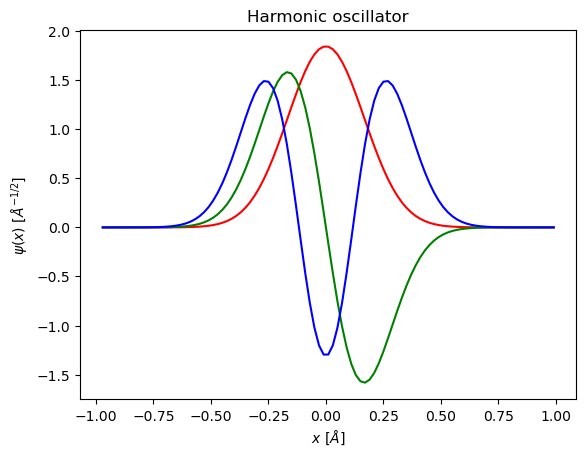

CPU times: user 1.38 s, sys: 1.65 s, total: 3.02 s
Wall time: 302 ms


In [ ]:
%%time

print("Using simple QR decomposition")
# Harmonic oscillator
Vpot = Vharm
Vlabel = "Harmonic oscillator"
A, Q = eigen_qr_simple(HamiltonianMatrix(Vpot),50)
indices = np.argsort(np.diag(A))
eigenvalues = np.diag(A)[indices]
eigenvectors = [Q[:,indices[i]] for i in range(len(indices))]
Nprint = 10
print("First", Nprint, "eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_", n, "=", eigenvalues[n]/e, "eV")

Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[i], dx)
    sign = 1
    if (integral_psi(eigenvectors[i], dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1.e-5*sign*eigenvectors[i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.legend()
plt.show()

First 10 eigenenergies of Anharmonic oscillator are
E_ 0 = 204.8415643532322 eV
E_ 1 = 732.3479746488032 eV
E_ 2 = 1432.2531583599684 eV
E_ 3 = 2228.057822724745 eV
E_ 4 = 3097.5257850925673 eV
E_ 5 = 4025.6461383175433 eV
E_ 6 = 5001.906288357331 eV
E_ 7 = 6018.30839402047 eV
E_ 8 = 7068.619615567106 eV
E_ 9 = 8148.325531154665 eV


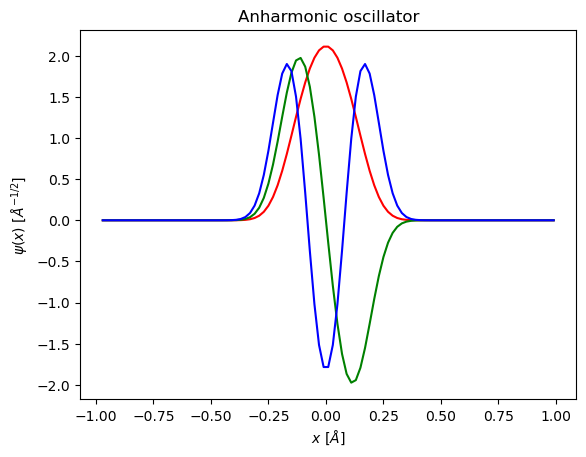

CPU times: user 1.48 s, sys: 922 ms, total: 2.4 s
Wall time: 274 ms


In [ ]:
%%time
# Anharmonic oscillator
Vpot = Vanharm
Vlabel = "Anharmonic oscillator"
A, Q = eigen_qr_simple(HamiltonianMatrix(Vpot),50)
indices = np.argsort(np.diag(A))
eigenvalues = np.diag(A)[indices]
eigenvectors = [Q[:,indices[i]] for i in range(len(indices))]
Nprint = 10
print("First", Nprint, "eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_", n, "=", eigenvalues[n]/e, "eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[i], dx)
    sign = 1
    if (integral_psi(eigenvectors[i], dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1.e-5*sign*eigenvectors[i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.legend()
plt.show()

We can also use efficient implementations of the eigenvalues/eigenvectors computation in `numpy.linalg.eigh`.

First 9 eigenenergies of Harmonic oscillator are
E_ 0 = 137.89885851582747 eV
E_ 1 = 413.4458926008785 eV
E_ 2 = 688.4908722176755 eV
E_ 3 = 963.0324138966929 eV
E_ 4 = 1237.0691216855612 eV
E_ 5 = 1510.5995897804717 eV
E_ 6 = 1783.622425735222 eV
E_ 7 = 2056.1364082137375 eV
E_ 8 = 2328.1413677481114 eV
CPU times: user 937 ms, sys: 533 ms, total: 1.47 s
Wall time: 271 ms


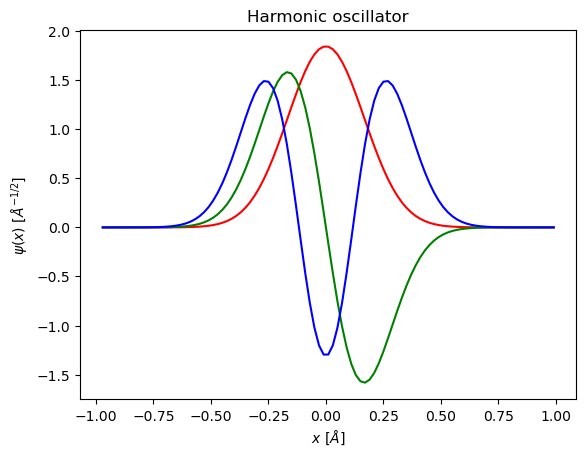

In [ ]:
%%time
Vpot = Vharm
Vlabel = "Harmonic oscillator"
eigenvalues, eigenvectors = np.linalg.eigh(HamiltonianMatrix(Vpot))
Nprint = 9
print("First", Nprint, "eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_", n, "=", eigenvalues[n]/e, "eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[:,i], dx)
    sign = 1
    if (integral_psi(eigenvectors[:,i],dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1e-5*sign*eigenvectors[:,i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.legend()
plt.show()

First 9 eigenenergies of Anharmonic oscillator are
E_ 0 = 204.841564353175 eV
E_ 1 = 732.3479746488514 eV
E_ 2 = 1432.253158359968 eV
E_ 3 = 2228.0578227239957 eV
E_ 4 = 3097.525784098384 eV
E_ 5 = 4025.6460160184683 eV
E_ 6 = 5001.902410892116 eV
E_ 7 = 6018.256522464476 eV
E_ 8 = 7068.232404050683 eV
CPU times: user 280 ms, sys: 387 ms, total: 667 ms
Wall time: 70.6 ms


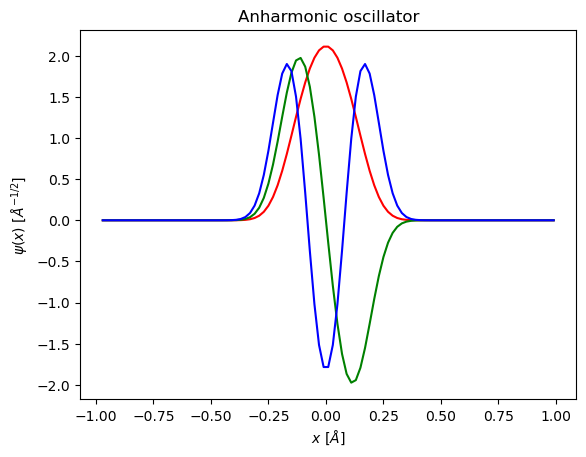

In [ ]:
%%time
Vpot = Vanharm
Vlabel = "Anharmonic oscillator"
eigenvalues, eigenvectors = np.linalg.eigh(HamiltonianMatrix(Vpot))
Nprint = 9
print("First", Nprint, "eigenenergies of", Vlabel, "are")
for n in range(Nprint):
    print("E_", n, "=", eigenvalues[n]/e, "eV")
    
Nplot = 3
colors = ['r','g','b']
xpoints = [(-0.5 * L + dx*(k+0.5))*1.e10 for k in range(1,N)]
plt.title(Vlabel)
plt.xlabel("${x~[\\AA]}$")
plt.ylabel("${\psi(x)~[\\AA^{-1/2}]}$")
for i in range(Nplot):
    norm = integral_psi2(eigenvectors[:,i], dx)
    sign = 1
    if (integral_psi(eigenvectors[:,i],dx) < 0.):
        sign = -1
    # Plot the wave-function
    plt.plot(xpoints,1e-5*sign*eigenvectors[:,i]/np.sqrt(norm),label='E = ' + "{:.3f}".format(eigenvalues[i]/e) + ' eV',color=colors[i])
plt.legend()
plt.show()